>[Cirq: Qubits, Operations, Moments and Circuits](#scrollTo=3340594dd8c1)

>>[Create a Circuit](#scrollTo=9768d38c9151)

>>[Exercise: Create a Circuit](#scrollTo=j0qHxsoyIrcj)

>>[Unpacking the circuit](#scrollTo=-06jQwEdI4DJ)

>>[More ways to create Circuits](#scrollTo=0bb8611c3865)

>>[Exercise: Create a circuit to left rotate 5 qubits.](#scrollTo=Z76Kcs27EcY5)

>[Qualtran: Resource Estimation and Very Large Scale Circuits](#scrollTo=nVuMhSm2lxiU)

>>[Basic Bloq](#scrollTo=lXixoICa8hXw)

>>[Exercise: Create a Bell's state](#scrollTo=xK1DTIdqqR-r)

>>>[Attempt the solution here](#scrollTo=n2EmgZEyql2g)

>>>[Expand to view the solution](#scrollTo=2id-xdR7qsEO)

>>[Quantum Variable](#scrollTo=A5BHn66w4xHS)

>>[Large size register](#scrollTo=cHSSWnaGk6tG)

>>[Protocols: Using Bloqs](#scrollTo=-3-vA57dAMUh)

>>>[Decomposition protocol:](#scrollTo=4U_AKyviKa8u)

>>>[Tensor protocol:](#scrollTo=gn54WZiunxyt)

>>>>[Exercise: Match the methods:](#scrollTo=lo29lrTINAdy)

>>>[Call Graph protocol](#scrollTo=T7NxVs1Pdy_-)

>>[Multi Pauli](#scrollTo=Zu2sBh08lFXv)

>>>[Exercise: Investigate MultiControlPauli](#scrollTo=9At671u7nQYm)

>>>>[Attempt solution here:](#scrollTo=Iv2TLLV8MAj1)

>>>>[Expand to view the solution](#scrollTo=mJ9bOiGhMLhL)

>[Qualtran-Cirq Interoperability](#scrollTo=e3a-V9aGAShh)

>>[Cirq Circuit to Bloq:](#scrollTo=LJsPI2g75Gne)

>>[Bloq to Cirq Circuit](#scrollTo=Zz0W3zPtJ6IS)

>>>[Bloq.as_cirq_op](#scrollTo=V6d27-X9KHbW)

>>>[CompositeBloq.to_cirq_circuit](#scrollTo=CprhjT1-5Qy3)

>>>[BloqAsCirqGate](#scrollTo=QRDDUaSfRqd_)



# Introduction:
In recent years, we have witnessed advancements in quantum technology. While better hardware is important to realize quantum advantage, quantum software also plays a crucial role. With the help of SDKs such as Cirq and Qiskit, quantum programs can be created and expressed in terms of quantum circuits. In some sense, Cirq and Qiskit are similar to quantum assembly languages, where quantum programs are created by adding elementary gates one by one. However, large-scale quantum programs requiring thousands of qubits and millions of operations (e.g., Shor's algorithm for factoring) demain more efficient management tools. To address this, we need something akin to the C programming language for quantum computing.

In this tutorial, we introduce Qualtran (Quantum Algorithms Translator): a set of abstractions for representing quantum programs and a library of quantum algorithms expressed in that language. The tutorial is composed of various parts in qualtran doc and come with some optional excersie. This notebook seek to give as all-in-one introduction to `Qualtran` infrastructure and answer to the following question:
1. How to define basic quantum program with `Qualtran` using `Bloq` ?
2. What is a protocol in `Qualtran` ?
3. How to translate `cirq.Circuit` to `Qualtran.Bloq`

# Basic Bloq

Similar to other quantum framework, `qualtran` come with a set of basic gates. All basic gates in qualtran inherit from `Bloq`: an abstract base class for all operation.  

In [1]:
from qualtran.bloqs.basic_gates import TGate, CNOT
c_not = CNOT()
t_gate = TGate()

In [2]:
from qualtran.drawing import show_bloqs

show_bloqs([t_gate, c_not], ['`t_gate`', 'c_not'])


By creating a new class inheriting `Bloq`, we can represent quantum program in various complexity in a a hierarchical collection of Python objects. The only mandatory methods to create a new Bloq is `Bloq.signature`. In the example below, we create a two qubits controlled gate with minimal information: class name and signature property.


In [3]:
from typing import *

import numpy as np
import sympy
import attrs

from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register, QBit,QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma

In [4]:
@attrs.frozen # this decorator is used to create classes with immutable instances
class CNOT(Bloq):
    @property
    def signature(self):
        return Signature([
            Register('ctrl', QBit()),
            Register('target', QBit())
        ])

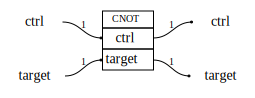

In [5]:
cg = CNOT()
show_bloq(cg)

This is the absolute minimum amount of information needed to define a Bloq: a name (i.e.
the class name) and a `signature` property.
The `Bloq.signature` property can be thought of as analogous
to the function signature in ordinary programming. You can think of a bloq
with just this property implemented like a function
declarations in a C header (`*.h`) file.

```
void CNOT(Qbit* control, Qbit* target);
```


There are many other methods we can optionally implement to encode more information about the bloq. We will examine each method in detail in another tutorial. The main idea is that new methods can be added to the bloq as we progress.

## Decomposing Bloqs:
Quantum operators can be decomposed into sub operators. In `Qualtran`, such operator can be define using `CompositeBloq`, a subclass of `Bloq`. In the example below, we define SWAP in terms of three CNOTs.

In [24]:
class SwapTwoBits(Bloq):
    @property

    def signature(self):
        # Signature.build(x=1, y=1) is an alternative syntax for this block
        return Signature([
            Register('x', QBit()),
            Register('y', QBit()),
        ])

    def build_composite_bloq(self, bb: BloqBuilder, *, x, y):
        x, y = bb.add(CNOT(), ctrl=x, target=y) # the bb.add(...) add sub operator
        y, x = bb.add(CNOT(), ctrl=y, target=x)
        x, y = bb.add(CNOT(), ctrl=x, target=y)
        return {'x': x, 'y': y}


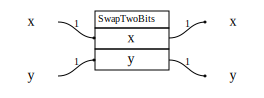

In [25]:
swapBloq = SwapTwoBits()
show_bloq(swapBloq)

In the example above the SWAP gate is defined by concatenating three CNOTs. If `show_bloq()` is used directly on `SwapTwoBits()`, the information implementation of the three CNOT gates won't be visible. To show a composite bloq we call the `decompose_bloq()` method.

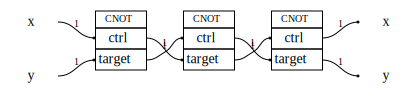

In [26]:
show_bloq(swapBloq.decompose_bloq())


Similarly, a SWAP can also be created using BloqBuilder directly. This approach can be useful for testing or prototyping.

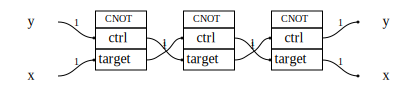

In [27]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
y, x = bb.add(CNOT(), ctrl=y, target=x)
x, y = bb.add(CNOT(), ctrl=x, target=y)
y, x = bb.add(CNOT(), ctrl=y, target=x)
cbloq = bb.finalize(x=x, y=y)
show_bloq(cbloq)

## Exercise: Create a Bell state

### Write your solution here

In [28]:
from qualtran.bloqs.basic_gates import CNOT, PlusState, ZeroState
## declare BloqBuilder

## add plus state

## add zero state

## entangle plus and zero state

## finalize and show bloq

### Expand to view the solution

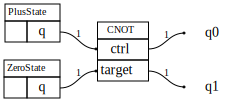

In [29]:
from qualtran.bloqs.basic_gates import CNOT, PlusState, ZeroState

bb = BloqBuilder()
q0 = bb.add(PlusState())
q1 = bb.add(ZeroState())

q0, q1 = bb.add(CNOT(), ctrl=q0, target=q1)

cbloq = bb.finalize(q0=q0, q1=q1)
show_bloq(cbloq)

## Quantum variables and Soquets.
In the example of SWAP bloq above `x, y` are quantum variables. In Qualtran quantum varibles have type `Soquet` and must follow the rules of quantum mechanics. All of these rule are enforced by `BloqBuilder`.

In [34]:
from qualtran import BloqError

bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)

try:
    _ = bb.add(CNOT(), ctrl=x, target=x)
except BloqError as e:
    print("Can't use a variable as both control and target!")
    print(e)

Can't use a variable as both control and target!
LeftDangle.x is not an available Soquet for `CNOT.target`.


In [35]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)

x2, y2 = bb.add(CNOT(), ctrl=x, target=y)

try:
    x3, y3 = bb.add(CNOT(), ctrl=x, target=y)
except BloqError as e:
    print("`x` and `y` were consumed by the first call to `add`.")
    print("Returned quantum variables are *new, immutable* variables that you use")
    print("in subsequent operations")
    print(e)


`x` and `y` were consumed by the first call to `add`.
Returned quantum variables are *new, immutable* variables that you use
in subsequent operations
LeftDangle.x is not an available Soquet for `CNOT.ctrl`.


In [36]:
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)

# The following line turns on the additional checks needed to
# raise an exception in this case:
bb.add_register_allowed = False

x2, y2 = bb.add(CNOT(), ctrl=x, target=y)
x3, y3 = bb.add(CNOT(), ctrl=x2, target=y2)

try:
    bb.finalize(x=x3)
except BloqError as e:
    print("Any unused variables must be 'passed on' to `finalize` to be outputs.")
    print(e)


Any unused variables must be 'passed on' to `finalize` to be outputs.
Finalizing requires a Soquet named `y`.


## Large registers

In [38]:
arr_reg = Register('arr', QAny(32), shape=(3, 3))
print('total bits:', arr_reg.total_bits())

total bits: 288


<div class="alert alert-block alert-info">`shape` is like `np.ndarray.shape`.</div>

In computing, we can think of all data as an ndarray of bits or qubits, but -- analogous to
classical data types -- it's preferable to treat a certain number of bits (or qubits) as
our atomic datatype. For example, in C, an array of `int32 x[10];` does not let you index
into individual bits like `x[3][31]`. Unlike in C, you are not limited by machine word size
for atomic type sizes, which is why above we could define a register of `bitsize=5`.

In the `SwapTwoBits` example everything was `bitsize=1` and we could write our decomposition
without slicing into the registers. Let's write a version of `Swap` that uses an array
of `bitsize=1` values.

Let's move on to a more complicated example where we create a `Bloq` that performs bitwise CNOT betwen two n-bits quantum registers.

This kind of operator will be useful to Quantum Error Correction, where we wish to apply logical CNOTs on two logical qubits. As mentioned before, it is not possible to index individual bits. To overcome this problem, you can change the shape of the Register or use `BloqBuilder.split()` and `BloqBuilder.join()` to manipulate the register.

In [42]:
"""
  Approach 1: use split() and join()
"""

@attrs.frozen
class BitwiseCnot2(Bloq):
    n: int
    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: BloqBuilder, *, x: SoquetT, y: SoquetT
    ) -> Dict[str, SoquetT]:
        xs = bb.split(x)
        ys = bb.split(y)

        for i in range(self.n):
            xs[i], ys[i] = bb.add(CNOT(), ctrl=xs[i], target=ys[i])
        return {
            'x': bb.join(xs),
            'y': bb.join(ys),
        }

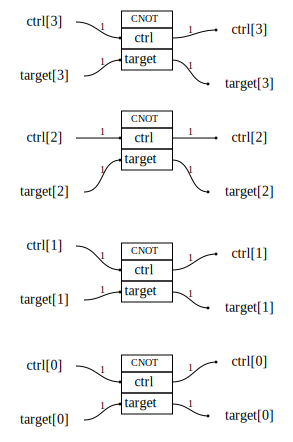

In [16]:
cbloq = BitwiseCnot1(n=4).decompose_bloq()
show_bloq(cbloq)

Another approach is to define use shape for register.

In [41]:
"""
  Approach 2: Change the shape of the register
"""

# SoquetT is defined to be either Soquet or ndarray of Soquet
# that is a quantum varible or n-darray of quantum varible.
from qualtran import SoquetT
@attrs.frozen
class BitwiseCnot1(Bloq):
    n: int
    @property
    def signature(self):
        return Signature([
            #`shape` is like `np.ndarray.shape`
            Register('ctrl', QBit(), shape=(self.n,)),
            Register('target', QBit(), shape=(self.n,)),
        ])

    def build_composite_bloq(
            self, bb: BloqBuilder, *, ctrl: SoquetT, target: SoquetT
    ) -> Dict[str, SoquetT]:
        for i in range(self.n):
            ctrl[i], target[i] = bb.add(CNOT(), ctrl=ctrl[i], target=target[i])
        return {'ctrl': ctrl, 'target': target}


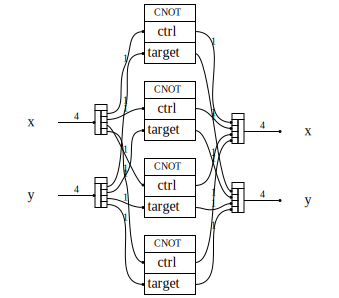

In [18]:
cbloq = BitwiseCnot2(n=4).decompose_bloq()
show_bloq(cbloq)

## Protocols: Using Bloqs

Put simply, `Protocol` is what we can do with `Bloq`. For a more precise definition of protocol:

> A protocol is a set of methods, functions, or procedures to structure a relevant piece of functionality.

A protocol is composed of:
* **The interface**: a method on `Bloq` that takes no arguments and returns a property of interest.
* **The implementation**: a method on `Bloq` that takes system-supplied arguments which `Bloq` authors can override to provide information for the protocol. This is the implementation.
* **A Python module**: functions for plumbing the implementation into the interface and other additional functionality.
* **Helper functions**: for implementing one protocol in terms of another called fallbacks. Some protocols have a default fallback that requires no special action from the `Bloq` author.



We can't do much with the `ControlledGate` from our earlier example because no protocol is associated with that `Bloq`. On the other hand, we can do much more with composite `Bloqs` because they support `Decomposition` protocol.

### Decomposition protocol:

* **Interface**: `decompose_bloq()`
This method provides a decomposition of a `Bloq` into its components.

* **Implementation**: `build_composite_bloq()`
This method is used to implement the decomposition protocol. Authors of bloqs can override this method to define how the bloq should be decomposed into its components.

* **Additional functionality**: `qualtran.BloqBuilder`
The qualtran.BloqBuilder class offers additional functionality for working with bloqs, enhancing the decomposition process.

* **Fallback**: `qualtran.DecomposeNotImplementedError`
If there is no specified fallback method for decomposing a bloq, this error will be raised to indicate that the decomposition is not implemented.










### Tensor protocol

The tensor protocol lets you query the tensor (vector, matrix, etc.) representation of a `Bloq`.
  * `add_my_tensors()`: This method is responsible for adding a tensor corresponding to the unitary, state, or effect of the bloq to the provided tensor network `tn`.
  * `tensor_contract()`:  Provides a tensor representation (vector or matrix) of a bloq or composite bloq.
  * `qualtran.simulation.tensor`:a module that contain a host of methods related to the tensor network.
  * `cbloq_as_contracted_tensor()`:the default fallback uses the decomposition protocol and this method


  







### Call Graph Protocol

* **Interface**: `call_graph()`
This method provides a directed-acyclic graph representing the hierarchical decomposition of bloqs.

* **Implementation**: `build_call_graph()`
The `build_call_graph()` method is used to implement the call graph protocol. Bloq authors can override this method to customize the generation of the call graph.

* **Additional functionality**: `qualtran.resource_counting`
The `qualtran.resource_counting` module offers additional functionality for working with call graphs, including resource counting and analysis.

* **Fallback**: Default fallback uses the Decomposition protocol and `build_cbloq_call_graph().`

If no specific method for generating the call graph is implemented for a `Bloq`, the default fallback utilizes the `Decomposition` protocol and `build_cbloq_call_graph()`

The number of protocols isn't limited to what have discussed in this tutorial. You can implement new protocol yourself. For the rest of this tutorial, we will focus on the `Call Graph` protocol and interoperabilty with Cirq.

# Qualtran-Cirq Interoperability

You might notice that syntactically, Qualtran and Cirq are very similar. They are, in fact, siblings, both created by Google. One feature of Qualtran is Cirq interoperability, and you can convert Cirq circuits to Bloqs and viceversa.

## Cirq Circuit to Bloq
Converting Cirq gates or circuits to Bloqs is fairly straightforward process. Basic gates in cirq are mapped to a corresponding `Bloq` while circuits are mapped into `CompositeBloq`  

In [19]:
# Converting cirq gate
from qualtran.cirq_interop import CirqGateAsBloq
import cirq

cgab = CirqGateAsBloq(cirq.QuantumFourierTransformGate(num_qubits=5))
print(cgab)
for reg in cgab.signature:
    print(' ', reg)

qft
  Register(name='q', dtype=QBit(), _shape=(5,), side=<Side.THRU: 3>)


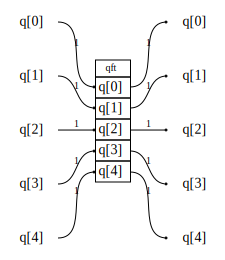

In [20]:
show_bloq(cgab)

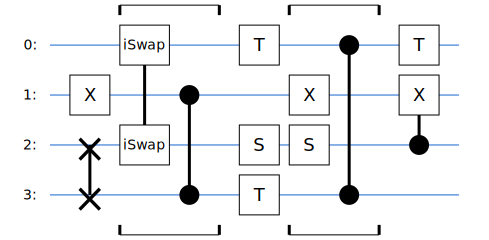

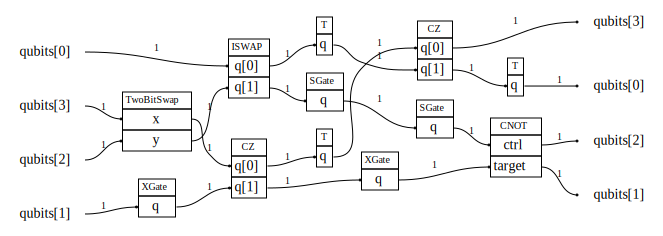

In [21]:
#Converting Cirq Circuit to CompositeBloq
from cirq.contrib.svg import SVGCircuit

# Make a random Cirq circuit
qubits = cirq.LineQubit.range(4)
circuit = cirq.testing.random_circuit(qubits, n_moments=5, op_density=1.0, random_state=52)

# Convert to CompositeBloq
cbloq = CompositeBloq.from_cirq_circuit(circuit)
display(SVGCircuit(circuit))
show_bloq(cbloq)

## Bloq to Cirq Circuit

### `Bloq.as_cirq_op`
This is an overridable method to declare what Cirq operation corresponds to a bloq. The `SwapTwoBits` in early example to `cirq.Swap` as follow:

In [47]:
from qualtran.cirq_interop import CirqQuregT
@attrs.frozen
class SwapTwoBits(Bloq):
    @property
    def signature(self):
        return Signature.build(x=1, y=1)

    def as_cirq_op(
            self, qubit_manager, x: CirqQuregT, y: CirqQuregT
    ) -> Tuple[cirq.Operation, Dict[str, CirqQuregT]]:
        x, = x  # each is an array of length one
        y, = y
        op = cirq.SWAP(x, y)
        out_quregs = {'x': [x], 'y': [y]}
        return op, out_quregs

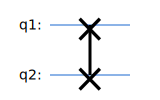

In [48]:
circuit, out_quregs = SwapTwoBits().as_composite_bloq()\
    .to_cirq_circuit_and_quregs(x=[cirq.NamedQubit('q1')], y=[cirq.NamedQubit('q2')])
SVGCircuit(circuit)

### `CompositeBloq.to_cirq_circuit`

A composite bloq can be turned into a circuit composed of the result of as_cirq_op for each of the subbloqs via CompositeBloq.to_cirq_circuit.
A bloq's Signature can be passed to a helper method get_named_qubits to instantiate Cirq qubits in the correct form for input to CompositeBloq.to_cirq_circuit_and_quregs. Users can also directly call CompositeBloq.to_cirq_circuit() which allocates the named qubits for you.

In [49]:
from qualtran._infra.gate_with_registers import get_named_qubits

get_named_qubits(SwapTwoBits().signature.lefts())


{'x': array([cirq.NamedQubit('x')], dtype=object),
 'y': array([cirq.NamedQubit('y')], dtype=object)}

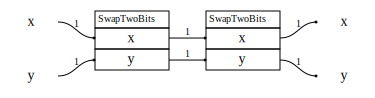

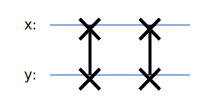

In [51]:
# Build a simple composite bloq
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
cbloq = bb.finalize(x=x, y=y)

# Turn it into a cirq circuit
circuit = cbloq.to_cirq_circuit()

# Observe
show_bloq(cbloq)
display(SVGCircuit(circuit))

### `BloqAsCirqGate`- Converting high level Bloq
For high-level bloq is very likely that there isn't an equivalent cirq gate. Moreover, for bloq can only be represented by large circuit, implementing `as_cirq_op` become tedious and impractical. Instead of overriding `as_cirq_op`, we use to its default implementation which wrap the `Bloq` inside `BloqAsCirqGate` and automatically return cirq operator.


In [52]:
from qualtran.cirq_interop import BloqAsCirqGate, cirq_optree_to_cbloq

@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: 'BloqBuilder', *, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        xs = bb.split(x)
        ys = bb.split(y)
        for i in range(self.n):
            xs[i], ys[i] = bb.add(SwapTwoBits(), x=xs[i], y=ys[i])
        return {'x': bb.join(xs), 'y': bb.join(ys)}

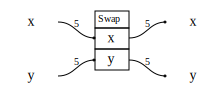

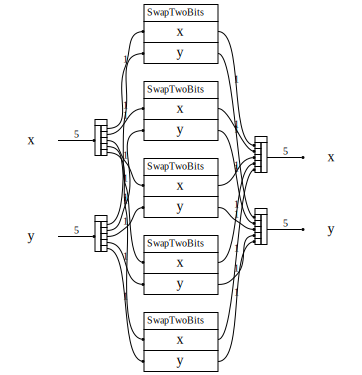

In [53]:
swap = Swap(n=5)

show_bloq(swap)
show_bloq(swap.decompose_bloq())

In [55]:
circuit = swap.as_composite_bloq().to_cirq_circuit(
    cirq_quregs= {'x':cirq.LineQubit.range(5), 'y':cirq.LineQubit.range(100,105)}
)

op = next(circuit.all_operations())

In [56]:
swap_decomp_circuit = cirq.Circuit(cirq.decompose_once(op))
print(repr(swap_decomp_circuit))

cirq.Circuit([
    cirq.Moment(
        cirq.SWAP(cirq.LineQubit(0), cirq.LineQubit(100)),
        cirq.SWAP(cirq.LineQubit(1), cirq.LineQubit(101)),
        cirq.SWAP(cirq.LineQubit(2), cirq.LineQubit(102)),
        cirq.SWAP(cirq.LineQubit(3), cirq.LineQubit(103)),
        cirq.SWAP(cirq.LineQubit(4), cirq.LineQubit(104)),
    ),
])


In [57]:
import qualtran.cirq_interop.testing as cq_testing
from qualtran.cirq_interop.jupyter_tools import display_gate_and_compilation

g = cq_testing.GateHelper(op.gate)
display_gate_and_compilation(g, include_costs=False)

# Appendix: Qualtran Multi Pauli

In this section we will use Call Graph protocol to investigate the cost of two gates: `MultiTargetCNOT`, `MultiControlPauli`.

In [58]:
from qualtran.bloqs.mcmt import MultiTargetCNOT, MultiControlPauli
import cirq

In [59]:
c_multi_not = MultiTargetCNOT(bitsize=5)

The primary method for accessing the call graph of a bloq is Bloq.call_graph(). It returns a `networkx` graph as well as a dictionary of totals for “leaf” bloqs.

Another method is `Bloq.bloq_counts`, which will return a dictionary of immediate children.

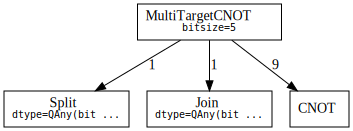

#### Counts totals:
 - `CNOT`: 9
 - `Join`: 1
 - `Split`: 1

In [60]:
from qualtran.resource_counting.generalizers import ignore_split_join
#c_multi_not_symb_g, c_multi_not_symb_sigma = c_multi_not.call_graph(max_depth=1, generalizer=ignore_split_join)
c_multi_not_symb_g, c_multi_not_symb_sigma = c_multi_not.call_graph()
show_call_graph(c_multi_not_symb_g)
show_counts_sigma(c_multi_not_symb_sigma)

Generally, two qubits gate and non Clifford gate are expensive due to their low fidelity. Call graph Protocol is then particulaly useful for estimating resource requirements for an algorithm. Note that you can also filter out irrelevent cost to your analysis by changing generalizer parameter of `call_graph()` methods. Uncomment the sencond line of above code block and observe the result.

### Exercise: Investigate MultiControlPauli

In [61]:
ccpauli = MultiControlPauli(cvs=(1, 0, 1, 0, 1), target_gate=cirq.X)

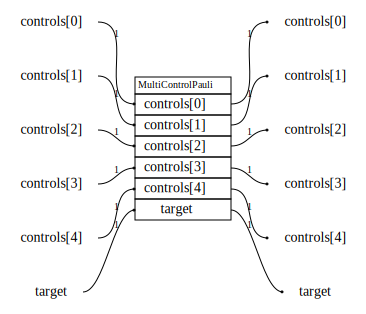

In [62]:
show_bloq(ccpauli)

#### Attempt solution here:

#### Expand to view the solution

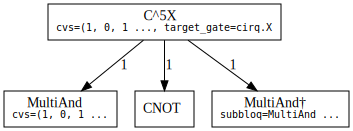

#### Counts totals:
 - `Adjoint(subbloq=MultiAnd(n=5))`: 1
 - `CNOT`: 1
 - `MultiAnd(n=5)`: 1

In [63]:


ccpauli_g, ccpauli_sigma = ccpauli.call_graph(max_depth=1, generalizer=ignore_split_join)
#ccpauli_g, ccpauli_sigma = ccpauli.call_graph()
show_call_graph(ccpauli_g)
show_counts_sigma(ccpauli_sigma)



# Appendix - Exercise Protocols: Match the methods:








Decide which method is the Interface the Implementation and Additional functionality
1. `add_my_tensors()`: ...
2. `tensor_contract()`: ...
3. `qualtran.simulation.tensor`: ...

# References:
This tutorial is based on on various part of qualtran doc. For a more throughout treatment, reader can consult the original material:
1. Bloq Tutorial: https://qualtran.readthedocs.io/en/latest/_infra/Bloqs-Tutorial.html
2. Protocol: https://qualtran.readthedocs.io/en/latest/Protocols.html
3. Multi Pauli: https://qualtran.readthedocs.io/en/latest/bloqs/mcmt/multi_control_multi_target_pauli.html

